In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import multivariate_normal
pd.options.mode.chained_assignment = None

In [2]:
N1 = 10
M1 = [7, 7]

N2 = 10
M2 = [-3, -3]

Iter = 30

Var = [5, 10, 30, 50]

In [3]:
def prepare_dataset(var):
    cov1 = np.array([[var, 0], [0, var]])
    cov2 = np.array([[var, 0], [0, var]])
    
    df1 = DataFrame(multivariate_normal(M1, cov1, N1), columns=['x', 'y'])
    df1['type'] = 1
    df2 = DataFrame(multivariate_normal(M2, cov2, N2), columns=['x', 'y'])
    df2['type'] = 0
    
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    return df

In [4]:
test = prepare_dataset(15)
test

,x,y,type
0,3.427291,7.068754,1
1,1.462379,0.508561,0
2,1.604310,-0.835805,0
3,4.482315,6.592761,1
4,-0.955105,-2.513657,0
5,0.639025,6.033851,1
6,-6.730163,-5.913565,0
7,3.738101,5.649520,1
8,6.908481,9.355434,1
9,-1.663132,-8.938958,0


In [5]:
def run_logistic(train_set, subplot):
    w = np.array([[0], [0.1], [0.1]])
    phi = train_set[['x', 'y']]
    phi['bias'] = 1
    phi = phi[['bias', 'x', 'y']].to_numpy()
    t = train_set[['type']]
    t = t.to_numpy()
    
    for i in range(Iter):
        y = np.array([])
        for line in phi:
            a = np.dot(line, w)
            y = np.append(y, [1.0/ (1.0 + np.exp(-a))])
        r = np.diag(y * (1-y))
        y = y[np.newaxis,:].T
        temp1 = np.linalg.inv(np.dot(np.dot(phi.T, r), phi))
        temp2 = np.dot(phi.T, (y-t))
        w_new = w - np.dot(temp1, temp2)
        
        if np.dot((w_new-w).T, (w_new-w)) < 0.001 * np.dot(w.T, w):
            w = w_new
            break
        w = w_new
    
    w0, w1, w2 = w[0], w[1], w[2]
    err = 0.0
    for index, point in train_set.iterrows():
        x, y, t = point.x, point.y, point.type
        t = t * 2 - 1
        if t * (w0 + w1*x + w2*y) < 0:
            err += 1
    err_rate = err * 100 / len(train_set)
    
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = -linex * w1 / w2 - w0 / w2
    label = f"ERR {err_rate:.2f}"
    subplot.plot(linex, liney, label=label, color='blue')
    subplot.legend(loc=1)

In [17]:
def run_perceptron(train_set, subplot):
    w0 = w1 = w2 = 0.0
    #bias = 1
    bias = 0.5 * (train_set.x.abs().mean() + train_set.y.abs().mean())
    
    for i in range(Iter):
        for index, point in train_set.iterrows():
            x, y, ty = point.x, point.y, point.type
            ty = ty * 2 - 1
            if ty * (w0 * bias + w1 * x + w2 * y) <=0:
                w0 += ty * bias
                w1 += ty * x
                w2 += ty * y
    
    err = 0.0
    for index, point in train_set.iterrows():
        x, y, ty = point.x, point.y, point.type
        ty = ty * 2 -1
        if ty * (w0 * bias + w1 * x + w2 * y) <=0:
            err += 1
    #print(err)
    err_rate = err * 100 / len(train_set)
    
    xmin, xmax = train_set.x.min()-5, train_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = -linex * w1 / w2 - w0 / w2
    label = f"ERR {err_rate:.2f}"
    subplot.plot(linex, liney, label=label, color='red', linestyle='--')
    subplot.legend(loc=1)

In [7]:
def run_simulation(variance, subplot):
    train = prepare_dataset(variance)
    train1 = train[train['type']==1]
    train2 = train[train['type']==0]
    ymin, ymax = train.y.min()-5, train.y.max()+5
    xmin, xmax = train.x.min()-5, train.x.max()+5
    
    subplot.set_ylim([ymin-1, ymax+1])
    subplot.set_xlim([xmin-1, xmax+1])
    subplot.scatter(train1.x, train1.y, marker='o', label=None)
    subplot.scatter(train2.x, train2.y, marker='x', label=None)
    
    run_logistic(train, subplot)
    run_perceptron(train, subplot)

<ipython-input-18-e1c1f1ac626b>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


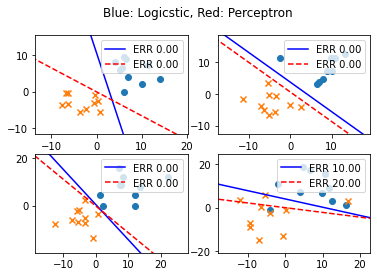

In [18]:
fig = plt.figure()
plt.suptitle('Blue: Logicstic, Red: Perceptron')
for c, variance in enumerate(Var):
    subplot = fig.add_subplot(2, 2, c+1)
    run_simulation(variance, subplot)
fig.show()